<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит вайл, не праильного офрмата или неверное окличество строк, метрика будет = 0.

In [15]:
import pandas as pd
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn import preprocessing, datasets, metrics, tree 
import lightgbm as lgb
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from featexp import get_univariate_plots

In [267]:
#загрузка данных
train = pd.read_csv('PD-data-train.csv', sep=';')
test = pd.read_csv('PD-data-test.csv', sep=';')
desc = pd.read_csv('PD-data-desc.csv', sep=';')

In [268]:
train.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


### Объединение трейн и тест данных с пропусками и без

#### Работа с полными данными

#### Работа с неполными данными

In [269]:
train_null = train.dropna(axis='columns')
train_null = train_null.loc[~train_null.index.isin(train_full.index)]

In [270]:
train_null.head()

,record_id,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
1,13,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
5,24,100,100,5,5,5,[1-100],350000.0,1,0,0,0,0
6,30,266,27,7,7,7,[1-100],35000.0,3,0,0,0,0
7,37,31,31,30,30,30,[1-100],10000.0,2,0,0,0,0


                                          Plots for ogrn_age                                          


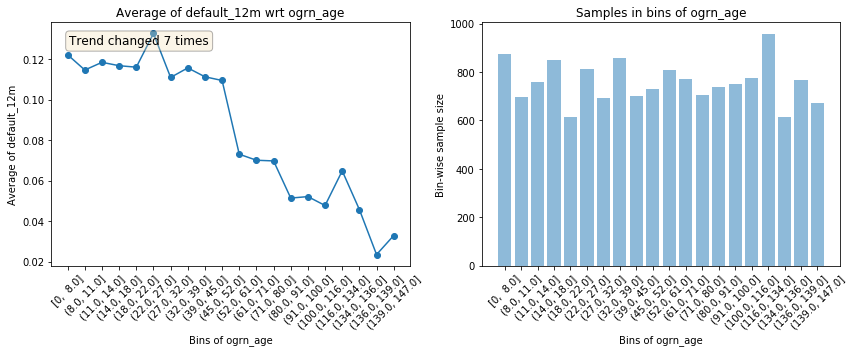

--------------------------------------------------------------------------------------------------------------




In [271]:
get_univariate_plots(data=train_null, target_col='default_12m', 
                     features_list=['ogrn_age'], bins=20)

                                       Plots for ul_capital_sum                                       


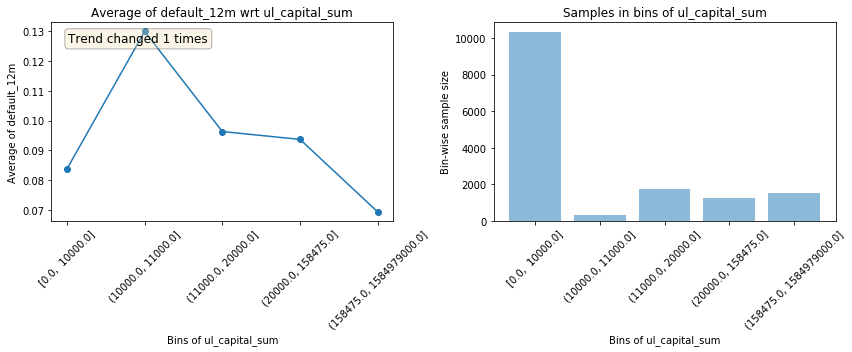

--------------------------------------------------------------------------------------------------------------




In [273]:
get_univariate_plots(data=train_null, target_col='default_12m', 
                     features_list=['ul_capital_sum'], bins=10)

                                          Plots for bus_age                                           


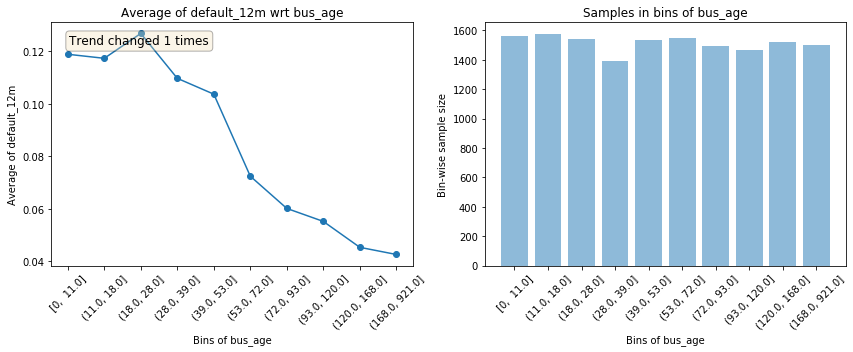

--------------------------------------------------------------------------------------------------------------




In [274]:
get_univariate_plots(data=train_null, target_col='default_12m', 
                     features_list=['bus_age'], bins=10)

                                       Plots for adr_actual_age                                       


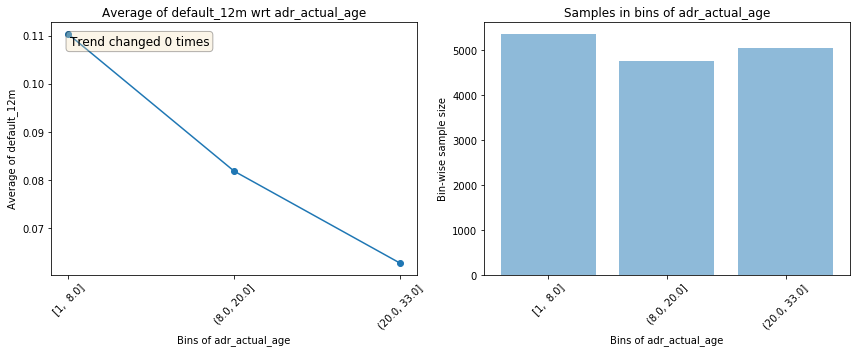

--------------------------------------------------------------------------------------------------------------




In [277]:
get_univariate_plots(data=train_null, target_col='default_12m', 
                     features_list=['adr_actual_age'], bins=3)

In [278]:
test_null = test.dropna(axis='columns')
test_null = test_null.loc[~test_null.index.isin(test_full.index)]

In [279]:
train_null_y = train_null['default_12m']
train_null = train_null.drop(['default_12m'], axis=1)

In [280]:
train_null.shape, test_null.shape

((15145, 12), (118, 12))

In [281]:
data_null_d = pd.concat([train_null, test_null], ignore_index=True)

#### Формирование переменных для полных данных

#### Формирование переменных для неполных данных

In [333]:
data_null = data_null_d.drop(['record_id', 'bus_age', 'ul_strategic_flg', 'ul_systematizing_flg'], axis = 1)

In [334]:
data_null.head()

,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt
0,135,12,12,12,[1-100],10000.0,5,0
1,33,28,28,28,[1-100],10000.0,2,0
2,100,5,5,5,[1-100],350000.0,1,0
3,27,7,7,7,[1-100],35000.0,3,0
4,31,30,30,30,[1-100],10000.0,2,0


In [335]:
data_null.loc[data_null.ogrn_age <= 45, 'ogrn_age_cat'] = 'young'
data_null.loc[data_null.ogrn_age > 45, 'ogrn_age_cat'] = 'old'

In [336]:
data_null.loc[data_null.adr_actual_age <= 8, 'actual_cat'] = 'small'
data_null.loc[(data_null.adr_actual_age > 8) & (data_null.adr_actual_age <= 20), 'actual_cat'] = 'Afternoon'
data_null.loc[data_null.adr_actual_age > 20, 'actual_cat'] = 'big'

In [337]:
data_null.head()

,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ogrn_age_cat,actual_cat
0,135,12,12,12,[1-100],10000.0,5,0,old,Afternoon
1,33,28,28,28,[1-100],10000.0,2,0,young,big
2,100,5,5,5,[1-100],350000.0,1,0,old,small
3,27,7,7,7,[1-100],35000.0,3,0,young,small
4,31,30,30,30,[1-100],10000.0,2,0,young,big


#### Построение базовой модели для полных данных

#### Построение базовой модели для неполных данных

In [338]:
X_train_null = data_null.iloc[:15145]
X_test_null = data_null.iloc[15145:]

In [339]:
y_train_null = train_null_y.iloc[:15145]
y_test_null = train_null_y.iloc[15145:]

In [340]:
X_train_null.shape, y_train_null.shape

((15145, 10), (15145,))

In [341]:
categ_feat = np.where(X_train_null.dtypes == 'object')[0]
categ_feat

array([4, 8, 9], dtype=int64)

In [342]:
X_null_part, X_null_valid, y_null_part, y_null_valid = train_test_split(X_train_null, y_train_null, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [343]:
X_null_part.shape, y_null_part.shape

((10601, 10), (10601,))

In [391]:
model_null = CatBoostRegressor(random_seed=17, silent=True, nan_mode='Forbidden')

In [392]:
%%time
model_null.fit(X_null_part, y_null_part,
        cat_features=categ_feat, verbose=False);

Wall time: 22.2 s


In [393]:
ctb_valid_pred_null = model_null.predict(X_null_valid)

In [394]:
roc_auc_score(y_null_valid, ctb_valid_pred_null)

0.6544352980118109

In [395]:
X_null_part.columns

Index(['ogrn_age', 'adr_actual_age', 'head_actual_age', 'cap_actual_age',
       'ul_staff_range', 'ul_capital_sum', 'ul_founders_cnt', 'ul_branch_cnt',
       'ogrn_age_cat', 'actual_cat'],
      dtype='object')

In [396]:
model_null.feature_importances_

array([34.32451446,  9.76445701,  5.83100647,  6.3228982 ,  1.89580735,
       24.37398267,  9.69043567,  0.08353828,  4.03774013,  3.67561975])

#### model_parameters validation

In [367]:
CBC = CatBoostRegressor(cat_features=categ_feat)

In [386]:
parameters = {'depth': [7], 'learning_rate': [0.1, 0.2, 0.3], 'iterations': [100, 1000]}

In [387]:
from sklearn.model_selection import GridSearchCV
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1)

In [388]:
Grid_CBC.fit(X_null_part, y_null_part)

0:	learn: 0.2789974	total: 9.22ms	remaining: 913ms
1:	learn: 0.2785966	total: 18ms	remaining: 883ms
2:	learn: 0.2780916	total: 33.8ms	remaining: 1.09s
3:	learn: 0.2777736	total: 39.2ms	remaining: 942ms
4:	learn: 0.2774758	total: 46.4ms	remaining: 882ms
5:	learn: 0.2772187	total: 57.1ms	remaining: 894ms
6:	learn: 0.2769989	total: 63.4ms	remaining: 842ms
7:	learn: 0.2767217	total: 69.6ms	remaining: 800ms
8:	learn: 0.2766053	total: 75.8ms	remaining: 767ms
9:	learn: 0.2763834	total: 81.6ms	remaining: 735ms
10:	learn: 0.2762760	total: 88.4ms	remaining: 715ms
11:	learn: 0.2761881	total: 95.4ms	remaining: 700ms
12:	learn: 0.2759998	total: 101ms	remaining: 679ms
13:	learn: 0.2758937	total: 108ms	remaining: 662ms
14:	learn: 0.2757559	total: 114ms	remaining: 649ms
15:	learn: 0.2756853	total: 121ms	remaining: 635ms
16:	learn: 0.2755650	total: 128ms	remaining: 626ms
17:	learn: 0.2754240	total: 138ms	remaining: 627ms
18:	learn: 0.2753682	total: 153ms	remaining: 651ms
19:	learn: 0.2752130	total: 158

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000278892663C8>,
             n_jobs=-1,
             param_grid={'depth': [7], 'iterations': [100, 1000],
                         'learning_rate': [0.1, 0.2, 0.3]})

In [389]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.021765214575576824

 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 100, 'learning_rate': 0.1}


#### экспорт результатов

In [397]:
cutoff_NN = model_full.predict(X_test_full)
cutoff_NN = sorted(cutoff_NN)[45]
predict  = (model_full.predict(X_test_full) >= cutoff_NN).astype(int)

cutoff_null = model_null.predict(X_test_null)
cutoff_null = sorted(cutoff_null)[54]
predict_null  = (model_null.predict(X_test_null)>= cutoff_null).astype(int)

test_full['predict'] = predict
test_null['predict'] = predict_null

answ_df = pd.concat([test_full['predict'], test_null['predict']])
answ_df.index.name = 'id'
answ_df.sort_index(inplace=True)
answ_df.to_csv('PD-submit.csv', index=True, sep=';')

C:\Users\Rollan\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  from ipykernel import kernelapp as app
